In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
import faircat
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb
import stats_utils
os.makedirs("data/pokec_faircat", exist_ok=True)

### Pokec-N

In [6]:
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_folder = os.path.join(ROOT, "real_world_data", "pokec_n")

edges = np.load(os.path.join(data_folder, "region_job_2_2_edges.npy"))
X_real = np.load(os.path.join(data_folder, "region_job_2_2_features.npy"))
Label_real = np.load(os.path.join(data_folder, "region_job_2_2_labels.npy"))
sens_real = np.load(os.path.join(data_folder, "region_job_2_2_sens.npy"))
k=len(set(Label_real))

In [7]:
print(X_real[:85])

[[ 0.6336214   0.41408557 -0.9312956  ... -0.21321952 -0.17112762
  -0.14535873]
 [ 0.6336214   0.41408557  1.0735993  ... -0.21321952 -0.17112762
  -0.14535873]
 [ 0.6336214   0.41408557 -0.9312956  ... -0.21321952 -0.17112762
  -0.14535873]
 ...
 [ 0.6336214  -0.3302094   1.0735993  ... -0.21321952 -0.17112762
  -0.14535873]
 [-1.5779744  -0.3302094   1.0735993  ... -0.21321952 -0.17112762
  -0.14535873]
 [ 0.6336214   0.8275828   1.0735993  ... -0.21321952 -0.17112762
  -0.14535873]]


In [ ]:
def to_csr_from_edges(edges, n=None, zero_indexed=True):
    E = np.asarray(edges)
    if E.shape[0] == 2 and E.shape[1] != 2:
        E = E.T
    if not zero_indexed:
        E = E - 1
    if n is None:
        n = int(E.max()) + 1
    A = sp.csr_matrix((np.ones(len(E), dtype=np.int8), (E[:,0], E[:,1])), shape=(n, n))
    A = A.maximum(A.T).tocsr()
    A.setdiag(0); A.eliminate_zeros()
    A.data[:] = 1
    return A

A_real = to_csr_from_edges(edges, zero_indexed=True)


In [6]:
print(Label_real.shape)

(6185,)


In [ ]:
k=2 # because Label_real is binary
n_0 = np.sum(sens_real == 0)
n_1 = np.sum(sens_real == 1)
max_deg_0 = np.max(A_real[sens_real == 0].sum(axis=1))
max_deg_1 = np.max(A_real[sens_real == 1].sum(axis=1))
d = (X_real.shape[1]+1) # number of attributes
deg_0 = np.sum(A_real[sens_real == 0].sum(axis=1))
deg_1 = np.sum(A_real[sens_real == 1].sum(axis=1))

corr_targets = {}


In [8]:
print(n_0, n_1)

4040 2145


In [14]:
print(d)

267


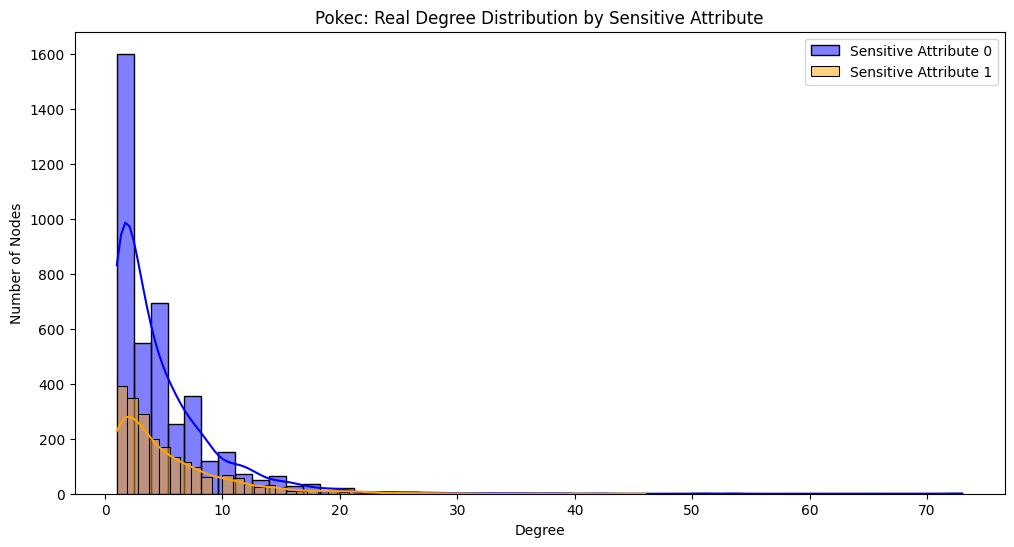

In [ ]:
deg_sequence = np.array(A_real.sum(axis=1)).flatten()
deg_0_sequence = np.array(A_real[sens_real == 0].sum(axis=1)).flatten()
deg_1_sequence = np.array(A_real[sens_real == 1].sum(axis=1)).flatten()
plt.figure(figsize=(12, 6))
sns.histplot(deg_0_sequence, bins=50, color='blue', label='Sensitive Attribute 0', kde=True)
sns.histplot(deg_1_sequence, bins=50, color='orange', label='Sensitive Attribute 1', kde=True)
plt.title('Pokec: Real Degree Distribution by Sensitive Attribute')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.legend()
plt.show()


In [10]:
# see what distribution it is
dist_type_0 = "powerlaw"
dist_type_1 = "powerlaw"

In [ ]:
M,D = faircat.class_reproduction(k,A_real,Label_real)


In [12]:
print("M:", M)
print("D:", D)

M: [[0.6458725  0.3541275 ]
 [0.43926103 0.56073897]]
D: [[0.31225312 0.31225312]
 [0.35917521 0.35917521]]


In [11]:
count_s0c0 = np.sum((sens_real == 0) & (Label_real == 0))
count_s0c1 = np.sum((sens_real == 0) & (Label_real == 1))
count_s1c0 = np.sum((sens_real == 1) & (Label_real == 0))
count_s1c1 = np.sum((sens_real == 1) & (Label_real == 1))

In [12]:
print(count_s0c0, count_s0c1, count_s1c0, count_s1c1)

2288 1752 1144 1001


In [13]:
count_s0c0_norm = count_s0c0 / n_0
count_s0c1_norm = count_s0c1 / n_0
count_s1c0_norm = count_s1c0 / n_1
count_s1c1_norm = count_s1c1 / n_1
print(count_s0c0_norm, count_s0c1_norm, count_s1c0_norm, count_s1c1_norm)

0.5663366336633663 0.43366336633663366 0.5333333333333333 0.4666666666666667


In [14]:
Pcg = [[count_s0c0_norm, count_s0c1_norm],[ count_s1c0_norm, count_s1c1_norm]]
Pcg

[[0.5663366336633663, 0.43366336633663366],
 [0.5333333333333333, 0.4666666666666667]]

In [15]:
from scipy.stats import chi2_contingency

table = [[count_s0c0, count_s0c1],
         [count_s1c0, count_s1c1]]

chi2, p, dof, expected = chi2_contingency(table)
print("Chi-squared Test:")
print(f"Chi2 Statistic: {chi2}, p-value: {p}, Degrees of Freedom: {dof}")

Chi-squared Test:
Chi2 Statistic: 6.045976762530175, p-value: 0.01393802005027737, Degrees of Freedom: 1


In [16]:
H = np.zeros((d-1, k))
for j in range(d-1):
    for c in range(k):
        mask = Label_real == c
        H[j, c] = X_real[mask, j].mean() if mask.any() else 0.0
    row_sum = H[j].sum()
    if row_sum > 0:
        H[j] /= row_sum
    else:
        H[j] = np.ones(k) / k
    H[j] = np.clip(H[j], 0.0, 1.0)
print(H.shape)

(266, 2)


In [22]:
print(H)

[[0.         1.        ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.47828353 0.52171647]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]


In [18]:
# correlation targets are 40 largest correlations
corr_with_label = np.corrcoef(np.c_[X_real, sens_real], rowvar=False)[-1, :-1]
idx = np.argsort(-np.abs(corr_with_label))[:d-2]
corr_targets = {int(i)+1: float(corr_with_label[i]) for i in idx}
print(corr_targets)

{4: 0.9999999999999951, 14: 0.16910138315137097, 237: -0.1016142124920271, 26: -0.09151566626113923, 168: -0.08993249367358674, 208: -0.07969280147012199, 181: 0.06613513365142425, 1: 0.06351951639518919, 12: 0.056647029216731946, 8: -0.05354700206540692, 211: 0.05168755525578706, 66: 0.05081433057722506, 38: 0.04968038692821372, 238: 0.047514543112077874, 88: 0.04610227634571853, 120: 0.04470369614549514, 119: 0.04470369614549514, 246: -0.04202094872087923, 96: 0.0418052087132616, 180: 0.04112456201257071, 148: -0.040596180239981336, 100: 0.0405741031391263, 80: 0.04037548722856629, 92: 0.03974569911491906, 62: 0.038687741517478814, 52: 0.03772558768688655, 29: 0.03747823709374859, 63: 0.03679415232034518, 95: 0.03642233019175286, 86: 0.03522226789498046, 145: 0.034519053509981516, 109: 0.03429243126154074, 125: 0.033994473878648165, 247: -0.03374903944505223, 220: -0.03346761823330674, 152: 0.0324657808107644, 39: -0.03241839889691442, 41: -0.03227400933533661, 60: 0.0316422581554543

In [ ]:
A, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="bernoulli",
            corr_targets=corr_targets,
            MAPE=True
        )


sum of degrees for group (target=19259): 19726
sum of degrees for group (target=11383): 11674
saturated attempts: 35288
number of generated edges : 15661


In [17]:
print(Label)
print(sorted_attr_group)

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 

In [18]:
print(deg_0, deg_1)

19259 11383


### Saving to npy

In [ ]:
adj = A.tocoo() if sp.issparse(A) else sp.coo_matrix(A)



mask = adj.row < adj.col  # keep one direction
edges = np.vstack((adj.row[mask], adj.col[mask])).astype(np.int64)


In [21]:
out_dir = r"data\pokec_n_faircat"
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "edges.npy"), edges)
np.save(os.path.join(out_dir, "features.npy"), X.astype(np.float32))
np.save(os.path.join(out_dir, "labels.npy"),   Label)
np.save(os.path.join(out_dir, "sens.npy"),   sorted_attr_group)

## Statistics, group=sens

In [ ]:
# real graph stats
intra, inter = stats_utils.inter_intra_counts(A_real, sens_real)
print("intra edges:", intra)
print("inter edges per group:", inter)

#intra-community density
sens_real = np.array(sens_real)
nc_0 = len(sens_real[sens_real == 0])
max_possible_0 = comb(nc_0, 2)
nc_1 = len(sens_real[sens_real == 1])
max_possible_1 = comb(nc_1, 2)

intra_density = 1/2*(1/max_possible_0*intra[0] + 1/max_possible_1*intra[1])
print("intra-community density:", intra_density)
print("intra-community density group 0: " + str(1/max_possible_0*intra[0]) )
print("intra-community density group 1: " + str(1/max_possible_1*intra[1]) )

#inter-community density
inter_density = (inter[0])/(nc_0*nc_1)
print("inter-community density:", inter_density)
print("LCC size:", stats_utils.lcc_size_numpy(A_real)[0])
print("LCC size_0:", stats_utils.lcc_size_numpy(A_real[sens_real == 0][:, sens_real == 0])[0])
print("LCC size_1:", stats_utils.lcc_size_numpy(A_real[sens_real == 1][:, sens_real == 1])[0])
print("number of components:", stats_utils.lcc_size_numpy(A_real)[1])
print("number of components_0:", stats_utils.lcc_size_numpy(A_real[sens_real == 0][:, sens_real == 0])[1])
print("number of components_1:", stats_utils.lcc_size_numpy(A_real[sens_real == 1][:, sens_real == 1])[1])
characteristic_path = stats_utils.characteristic_path_length(A_real)
characteristic_path_0 = stats_utils.characteristic_path_length(A_real[sens_real == 0][:, sens_real == 0])
characteristic_path_1 = stats_utils.characteristic_path_length(A_real[sens_real == 1][:, sens_real == 1])
print("characteristic path length:", characteristic_path)
print("characteristic path length_0:", characteristic_path_0)
print("characteristic path length_1:", characteristic_path_1)

intra edges: {0: 9274, 1: 5336}
inter edges per group: {0: 711, 1: 711}
intra-community density: 0.0017286272806038292
intra-community density group 0: 0.0011366895540754869
intra-community density group 1: 0.0023205650071321713
inter-community density: 8.204666620508205e-05
LCC size: 6185
LCC size_0: 3925
LCC size_1: 2079
number of components: 1
number of components_0: 87
number of components_1: 48
characteristic path length: 6.0665993865306564
characteristic path length_0: 5.726100755111449
characteristic path length_1: 5.180883957592331


In [ ]:
print(A_real[sens_real == 0][:, sens_real == 0])
print(A_real[sens_real == 1][:, sens_real == 1])
print(A_real)

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 18548 stored elements and shape (4040, 4040)>
  Coords	Values
  (0, 138)	1
  (0, 559)	1
  (0, 1188)	1
  (0, 1911)	1
  (1, 1517)	1
  (1, 2460)	1
  (1, 3178)	1
  (1, 3612)	1
  (2, 816)	1
  (2, 1158)	1
  (2, 1220)	1
  (2, 1225)	1
  (2, 1857)	1
  (2, 1949)	1
  (2, 2016)	1
  (2, 2730)	1
  (2, 3564)	1
  (3, 2234)	1
  (3, 2894)	1
  (3, 3234)	1
  (3, 3830)	1
  (4, 667)	1
  (4, 2322)	1
  (4, 4016)	1
  (5, 283)	1
  :	:
  (4037, 1873)	1
  (4038, 13)	1
  (4038, 261)	1
  (4038, 916)	1
  (4038, 1131)	1
  (4038, 1306)	1
  (4038, 1472)	1
  (4038, 1670)	1
  (4038, 1808)	1
  (4038, 1962)	1
  (4038, 2254)	1
  (4038, 2281)	1
  (4038, 2331)	1
  (4038, 2679)	1
  (4038, 3058)	1
  (4038, 3149)	1
  (4038, 3290)	1
  (4038, 3350)	1
  (4038, 3729)	1
  (4038, 3738)	1
  (4038, 3883)	1
  (4039, 541)	1
  (4039, 1816)	1
  (4039, 2441)	1
  (4039, 3747)	1
<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 10672 stored elements and shape (2145, 2145)>
  C

In [ ]:
# fake graph statistics
for i in range(5):
    A, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="bernoulli",
            corr_targets=corr_targets,
            MAPE=True
        )
    intra, inter = stats_utils.inter_intra_counts(A, sorted_attr_group)
    print("intra edges:", intra)
    print("inter edges per group:", inter)

    #intra-community density
    sorted_attr_group = np.array(sorted_attr_group)
    nc_0 = len(sorted_attr_group[sorted_attr_group == 0])
    max_possible_0 = comb(nc_0, 2)
    nc_1 = len(sorted_attr_group[sorted_attr_group == 1])
    max_possible_1 = comb(nc_1, 2)
    intra_density = 1/2*(1/max_possible_0*intra[0] + 1/max_possible_1*intra[1])
    intra_density_0 = 1/max_possible_0*intra[0]
    intra_density_1 = 1/max_possible_1*intra[1]
    

    #inter-community density
    inter_density = (inter[0])/(nc_0*nc_1)

    print("LLC size:", stats_utils.lcc_size_numpy(A)[0])
    print("LCC size_0:", stats_utils.lcc_size_numpy(A[sorted_attr_group == 0][:, sorted_attr_group == 0])[0])
    print("LCC size_1:", stats_utils.lcc_size_numpy(A[sorted_attr_group == 1][:, sorted_attr_group == 1])[0])
    print("number of components:", stats_utils.lcc_size_numpy(A)[1])
    print("number of components_0:", stats_utils.lcc_size_numpy(A[sorted_attr_group == 0][:, sorted_attr_group == 0])[1])
    print("number of components_1:", stats_utils.lcc_size_numpy(A[sorted_attr_group == 1][:, sorted_attr_group == 1])[1])
    characteristic_path = stats_utils.characteristic_path_length(A)
    characteristic_path_0 = stats_utils.characteristic_path_length(A[sorted_attr_group == 0][:, sorted_attr_group == 0])
    characteristic_path_1 = stats_utils.characteristic_path_length(A[sorted_attr_group == 1][:, sorted_attr_group == 1])
    
    
print("intra-community average:", np.mean(intra_density))
print("intra-group densities group 0 average:", np.mean(intra_density_0))
print("intra-group densities group 1 average:", np.mean(intra_density_1))
print("inter-community average:", np.mean(inter_density))
print("average path length average:", np.mean(characteristic_path))
print("average characteristic path length_0:", np.mean(characteristic_path_0))
print("average characteristic path length_1:", np.mean(characteristic_path_1))

sum of degrees for group (target=19259): 19474
sum of degrees for group (target=11383): 11406
saturated attempts: 32294
number of generated edges : 15414
intra edges: {0: 6160, 1: 2138}
inter edges per group: {0: 7116, 1: 7116}
LLC size: 6185
LCC size_0: 3515
LCC size_1: 1446
number of components: 1
number of components_0: 525
number of components_1: 691
sum of degrees for group (target=19259): 19546
sum of degrees for group (target=11383): 11923
saturated attempts: 34526
number of generated edges : 15703
intra edges: {0: 5991, 1: 2182}
inter edges per group: {0: 7530, 1: 7530}
LLC size: 6184
LCC size_0: 3379
LCC size_1: 1484
number of components: 2
number of components_0: 661
number of components_1: 660
sum of degrees for group (target=19259): 19880
sum of degrees for group (target=11383): 11430
saturated attempts: 35681
number of generated edges : 15624
intra edges: {0: 6287, 1: 2080}
inter edges per group: {0: 7257, 1: 7257}
LLC size: 6184
LCC size_0: 3519
LCC size_1: 1416
number of

### Statistics, group = class

In [ ]:
# real graph stats
intra, inter = stats_utils.inter_intra_counts(A_real, Label_real)
print("intra edges:", intra)
print("inter edges per group:", inter)

#intra-community density
Label_real = np.array(Label_real)
nc_0 = len(Label_real[Label_real == 0])
max_possible_0 = comb(nc_0, 2)
nc_1 = len(Label_real[Label_real == 1])
max_possible_1 = comb(nc_1, 2)

intra_density = 1/2*(1/max_possible_0*intra[0] + 1/max_possible_1*intra[1])
print("intra-community density:", intra_density)
print("intra-community density group 0: " + str(1/max_possible_0*intra[0]) )
print("intra-community density group 1: " + str(1/max_possible_1*intra[1]) )

#inter-community density
inter_density = (inter[0])/(nc_0*nc_1)
print("inter-community density:", inter_density)
print("LCC size:", stats_utils.lcc_size_numpy(A_real)[0])
print("LCC size_0:", stats_utils.lcc_size_numpy(A_real[Label_real == 0][:, Label_real == 0])[0])
print("LCC size_1:", stats_utils.lcc_size_numpy(A_real[Label_real == 1][:, Label_real == 1])[0])
print("number of components:", stats_utils.lcc_size_numpy(A_real)[1])
print("number of components_0:", stats_utils.lcc_size_numpy(A_real[Label_real == 0][:, Label_real == 0])[1])
print("number of components_1:", stats_utils.lcc_size_numpy(A_real[Label_real == 1][:, Label_real == 1])[1])
characteristic_path = stats_utils.characteristic_path_length(A_real)
characteristic_path_0 = stats_utils.characteristic_path_length(A_real[Label_real == 0][:, Label_real == 0])
characteristic_path_1 = stats_utils.characteristic_path_length(A_real[Label_real == 1][:, Label_real == 1])
print("characteristic path length:", characteristic_path)
print("characteristic path length_0:", characteristic_path_0)
print("characteristic path length_1:", characteristic_path_1)

intra edges: {0: 5647, 1: 3375}
inter edges per group: {0: 6299, 1: 6299}
intra-community density: 0.0009250382434419441
intra-community density group 0: 0.0009591351036993706
intra-community density group 1: 0.0008909413831845176
inter-community density: 0.0006666810607965711
LCC size: 6185
LCC size_0: 2920
LCC size_1: 1992
number of components: 1
number of components_0: 405
number of components_1: 561
characteristic path length: 6.0665993865306564
characteristic path length_0: 6.809712934153656
characteristic path length_1: 8.033774979375059


In [ ]:
# fake graph statistics
for i in range(5):
    A, X, Label, theta, sorted_attr_group = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="bernoulli",
            corr_targets=corr_targets,
            MAPE=True
        )
    intra, inter = stats_utils.inter_intra_counts(A, Label)
    print("intra edges:", intra)
    print("inter edges per group:", inter)

    #intra-community density
    Label = np.array(Label)
    nc_0 = len(Label[Label == 0])
    max_possible_0 = comb(nc_0, 2)
    nc_1 = len(Label[Label == 1])
    max_possible_1 = comb(nc_1, 2)
    intra_density = 1/2*(1/max_possible_0*intra[0] + 1/max_possible_1*intra[1])
    intra_density_0 = 1/max_possible_0*intra[0]
    intra_density_1 = 1/max_possible_1*intra[1]
    

    #inter-community density
    inter_density = (inter[0])/(nc_0*nc_1)

    print("LLC size:", stats_utils.lcc_size_numpy(A)[0])
    print("LCC size_0:", stats_utils.lcc_size_numpy(A[Label == 0][:, Label == 0])[0])
    print("LCC size_1:", stats_utils.lcc_size_numpy(A[Label == 1][:, Label == 1])[0])
    print("number of components:", stats_utils.lcc_size_numpy(A)[1])
    print("number of components_0:", stats_utils.lcc_size_numpy(A[Label == 0][:, Label == 0])[1])
    print("number of components_1:", stats_utils.lcc_size_numpy(A[Label == 1][:, Label == 1])[1])
    characteristic_path = stats_utils.characteristic_path_length(A)
    characteristic_path_0 = stats_utils.characteristic_path_length(A[Label == 0][:, Label == 0])
    characteristic_path_1 = stats_utils.characteristic_path_length(A[Label == 1][:, Label == 1])
    
    
print("intra-community average:", np.mean(intra_density))
print("intra-group densities group 0 average:", np.mean(intra_density_0))
print("intra-group densities group 1 average:", np.mean(intra_density_1))
print("inter-community average:", np.mean(inter_density))
print("average path length average:", np.mean(characteristic_path))
print("average characteristic path length_0:", np.mean(characteristic_path_0))
print("average characteristic path length_1:", np.mean(characteristic_path_1))

sum of degrees for group (target=19259): 19626
sum of degrees for group (target=11383): 12861
saturated attempts: 36492
number of generated edges : 16209
intra edges: {0: 5035, 1: 3545}
inter edges per group: {0: 7629, 1: 7629}
LLC size: 6185
LCC size_0: 2737
LCC size_1: 2105
number of components: 1
number of components_0: 615
number of components_1: 728
sum of degrees for group (target=19259): 19729
sum of degrees for group (target=11383): 11877
saturated attempts: 35110
number of generated edges : 15768
intra edges: {0: 5423, 1: 2919}
inter edges per group: {0: 7426, 1: 7426}
LLC size: 6185
LCC size_0: 2938
LCC size_1: 1884
number of components: 1
number of components_0: 536
number of components_1: 828
sum of degrees for group (target=19259): 19323
sum of degrees for group (target=11383): 11398
saturated attempts: 34863
number of generated edges : 15327
intra edges: {0: 4684, 1: 3368}
inter edges per group: {0: 7275, 1: 7275}
LLC size: 6184
LCC size_0: 2746
LCC size_1: 2078
number of

## MAPE

In [ ]:
# compute mape
A = A.tocsr()
A.setdiag(0)
if hasattr(A, "eliminate_zeros"):
    A.eliminate_zeros()
if A.nnz:
    A.data[:] = 1

theta_actual = np.array(A.sum(axis=1)).ravel().astype(float)
theta_target = np.asarray(theta, float)
theta_target = np.clip(theta_target, 1e-12, None)

mape_total = np.mean(np.abs(theta_actual - theta_target) / theta_target)

g = np.asarray(sorted_attr_group)
mape_0 = np.mean(np.abs(theta_actual[g==0] - theta_target[g==0]) / theta_target[g==0])
mape_1 = np.mean(np.abs(theta_actual[g==1] - theta_target[g==1]) / theta_target[g==1])

In [29]:
print("Overall MAPE:", f"{mape_total:.2e}")
print("MAPE for sensitive attribute 0:", f"{mape_0:.2e}")
print("MAPE for sensitive attribute 1:", f"{mape_1:.2e}")

Overall MAPE: 2.49e-03
MAPE for sensitive attribute 0: 2.81e-03
MAPE for sensitive attribute 1: 1.89e-03


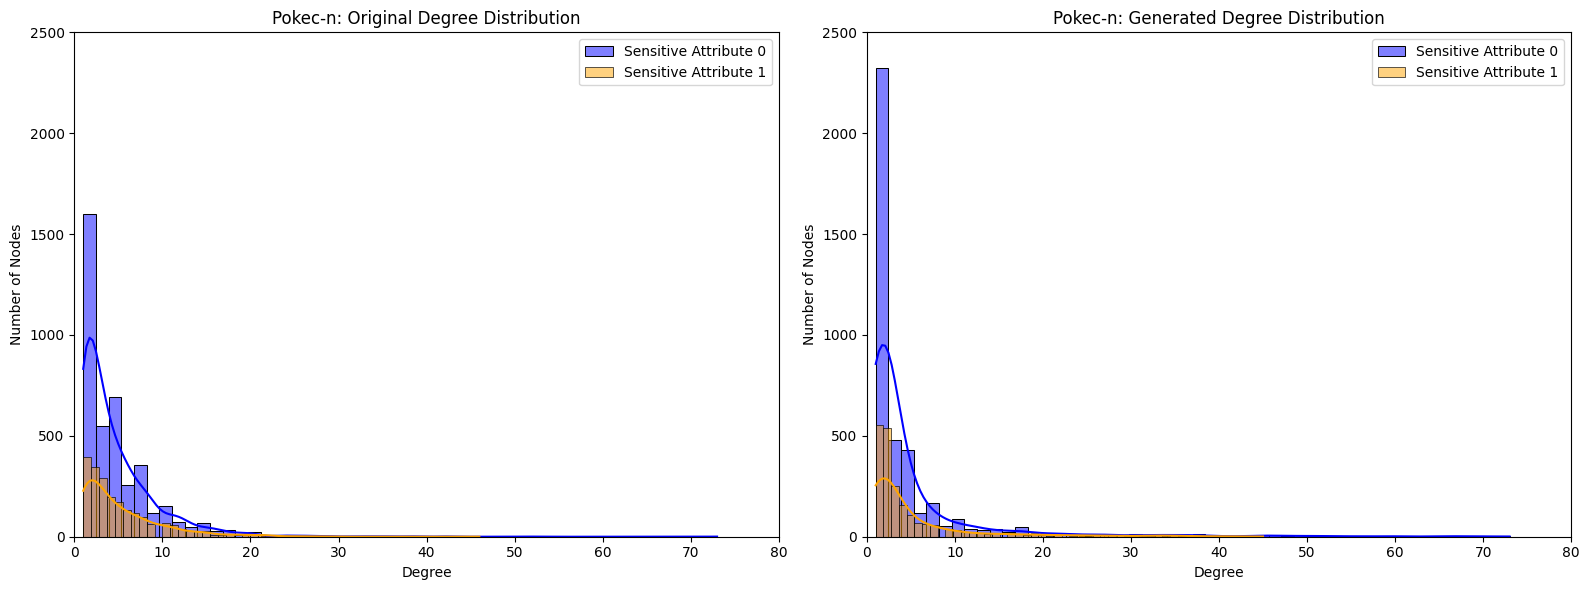

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# real graph
deg_0 = np.array(A_real[sens_real == 0].sum(axis=1)).flatten()
deg_1 = np.array(A_real[sens_real == 1].sum(axis=1)).flatten()

sns.histplot(deg_0, bins=50, color='blue', kde=True, ax=axes[0], label='Sensitive Attribute 0')
sns.histplot(deg_1, bins=50, color='orange', kde=True, ax=axes[0], label='Sensitive Attribute 1')

axes[0].set_title('Pokec-n: Original Degree Distribution')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Number of Nodes')
axes[0].set_xlim(0, 80)
axes[0].set_ylim(0, 2500)
axes[0].legend()

# fake graph
deg_0_gen = np.array(A[X[:, 0] == 0].sum(axis=1)).flatten()
deg_1_gen = np.array(A[X[:, 0] == 1].sum(axis=1)).flatten()

sns.histplot(deg_0_gen, bins=50, color='blue', kde=True, ax=axes[1], label='Sensitive Attribute 0')
sns.histplot(deg_1_gen, bins=50, color='orange', kde=True, ax=axes[1], label='Sensitive Attribute 1')

axes[1].set_title('Pokec-n: Generated Degree Distribution')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Number of Nodes')
axes[1].set_xlim(0, 80)
axes[1].set_ylim(0, 2500)
axes[1].legend()

plt.tight_layout()
plt.show()


### Target correlations

In [31]:
# correlation targets are 40 largest correlations
corr_with_label = np.corrcoef(np.c_[X_real, sens_real], rowvar=False)[-1, :-1]
idx = np.argsort(-np.abs(corr_with_label))[:40]
corr_targets = {int(i)+1: float(corr_with_label[i]) for i in idx}
print(corr_targets)

{4: 0.9999999999999951, 14: 0.16910138315137097, 237: -0.1016142124920271, 26: -0.09151566626113923, 168: -0.08993249367358674, 208: -0.07969280147012199, 181: 0.06613513365142425, 1: 0.06351951639518919, 12: 0.056647029216731946, 8: -0.05354700206540692, 211: 0.05168755525578706, 66: 0.05081433057722506, 38: 0.04968038692821372, 238: 0.047514543112077874, 88: 0.04610227634571853, 120: 0.04470369614549514, 119: 0.04470369614549514, 246: -0.04202094872087923, 96: 0.0418052087132616, 180: 0.04112456201257071, 148: -0.040596180239981336, 100: 0.0405741031391263, 80: 0.04037548722856629, 92: 0.03974569911491906, 62: 0.038687741517478814, 52: 0.03772558768688655, 29: 0.03747823709374859, 63: 0.03679415232034518, 95: 0.03642233019175286, 86: 0.03522226789498046, 145: 0.034519053509981516, 109: 0.03429243126154074, 125: 0.033994473878648165, 247: -0.03374903944505223, 220: -0.03346761823330674, 152: 0.0324657808107644, 39: -0.03241839889691442, 41: -0.03227400933533661, 60: 0.0316422581554543

In [ ]:
deg_0 = float(deg_0.sum())  
deg_1 = float(deg_1.sum())

A, X, Label = faircat.faircat(
            n_0, n_1, deg_0, deg_1,
            k, d, max_deg_0, max_deg_1,
            dist_type_0, dist_type_1,
            Pcg, M, D, H,
            att_type="bernoulli",
            corr_targets=corr_targets
        )


sum of degrees for group (target=19259.0): 19761
sum of degrees for group (target=11383.0): 12158
saturated attempts: 36536
number of generated edges : 15927


In [33]:

corr_index= np.array([first for first, _ in corr_targets.items()])
corr_targets_values = np.array([second for _, second in corr_targets.items()])
sens_generated = X[:, 0].astype(float)
corr_generated = []
for idx in corr_index:
    x_col = X[:, idx].astype(float)
    corr_value = np.corrcoef(x_col, sens_generated)[0, 1]
    corr_generated.append(corr_value)
print(corr_generated,corr_targets_values)

[0.735878923968164, 0.1690188779343877, -0.10142512165579039, -0.09177692989565846, -0.09018325025743018, -0.07936118524354759, 0.06621598190784887, 0.06369132962099973, 0.056865159118056674, -0.05350576672670484, 0.05155656279858361, 0.05076923183441451, 0.04981983712098341, 0.047183066051497254, 0.0462299888144534, 0.04498708784499949, 0.04463892830920577, -0.042302153299714464, 0.04212633082786635, 0.04108237654807041, -0.0406523002098528, 0.04079571268511801, 0.04060527345913483, 0.039627101411708, 0.03896899482445975, 0.037857561492889345, 0.037148761994532306, 0.03709105653378159, 0.03636722802257844, 0.035119176035031334, 0.0347838355723528, 0.0340004898131154, 0.03373773287176688, -0.03358388784739653, -0.033140678342632506, 0.03225956341415451, -0.03212625775591863, -0.03201679290304424, 0.0318216649031265, 0.031168218545313493] [ 1.          0.16910138 -0.10161421 -0.09151567 -0.08993249 -0.0796928
  0.06613513  0.06351952  0.05664703 -0.053547    0.05168756  0.05081433
  0.0

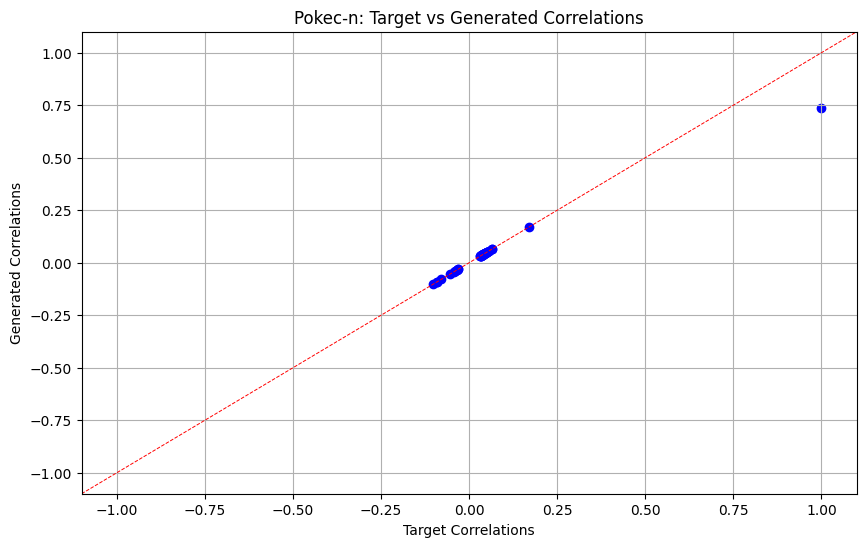

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(corr_targets_values, corr_generated, color='blue')
xlim = plt.xlim(-1.1, 1.1)
ylim = plt.ylim(-1.1, 1.1)
plt.plot(xlim, ylim, color='red', linestyle='--', label='y=x', linewidth=0.7)
plt.xlabel('Target Correlations')
plt.ylabel('Generated Correlations')
plt.title('Pokec-n: Target vs Generated Correlations')
plt.grid(True)
plt.show()

[PRE ] corr(col 2, s) = 0.0316
[POST] corr(col 2, s) = 0.7359


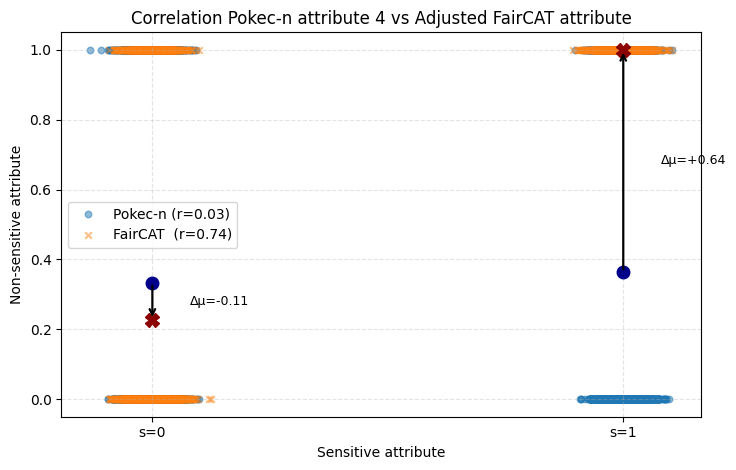

In [ ]:

s_pre  = Label_real.astype(float)
x2_pre = X_real[:, 3].astype(float)

s_post  = X[:, 0].astype(float)
x2_post = X[:, 4].astype(float)

def _safe_corr(a, b):
    a = np.asarray(a, float).ravel()
    b = np.asarray(b, float).ravel()
    if (np.std(a) < 1e-12) or (np.std(b) < 1e-12):
        return float('nan')
    return float(np.corrcoef(a, b)[0, 1])

r_pre  = _safe_corr(x2_pre,  s_pre)
r_post = _safe_corr(x2_post, s_post)

print(f"[PRE ] corr(col 2, s) = {r_pre:.4f}")
print(f"[POST] corr(col 2, s) = {r_post:.4f}")

plt.figure(figsize=(7.5, 4.8))

rng = np.random.default_rng(42)
s_pre_j  = s_pre  + rng.normal(0, 0.03, size=s_pre.shape[0])
s_post_j = s_post + rng.normal(0, 0.03, size=s_post.shape[0])

plt.scatter(s_pre_j,  x2_pre,  alpha=0.5, s=22, label=f"Pokec-n (r={r_pre:.2f})")
plt.scatter(s_post_j, x2_post, alpha=0.5, s=22, marker='x', label=f"FairCAT  (r={r_post:.2f})")

def group_mean(values, groups, gval):
    m = values[np.isclose(groups, gval)]
    return np.nan if m.size == 0 else float(np.mean(m))

for g in (0.0, 1.0):
    mu_pre  = group_mean(x2_pre,  s_pre,  g)
    mu_post = group_mean(x2_post, s_post, g)

    if not (np.isnan(mu_pre) or np.isnan(mu_post)):
        # mean markers
        plt.plot([g], [mu_pre],  marker='o', ms=9, color='darkblue',  label=None)
        plt.plot([g], [mu_post], marker='X', ms=10, color='darkred',  label=None)

        plt.annotate(
            "", xy=(g, mu_post), xytext=(g, mu_pre),
            arrowprops=dict(arrowstyle="->", lw=1.6, color='black')
        )

        dmu = mu_post - mu_pre
        plt.text(g + 0.08, (mu_pre + mu_post)/2,
                 f"Δμ={dmu:+.2f}", va="center", fontsize=9)

plt.xticks([0, 1], ["s=0", "s=1"])
plt.xlabel("Sensitive attribute")
plt.ylabel("Non-sensitive attribute")
plt.title("Correlation Pokec-n attribute 4 vs Adjusted FairCAT attribute")
plt.grid(True, ls='--', alpha=0.35)
plt.legend(loc="best")
plt.tight_layout()

plt.show()

